# Analysis of My Music/Health Data

## Imports & configurations

In [488]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import garminconnect
from datetime import timedelta, datetime
from lyricsgenius import Genius
from dotenv import load_dotenv
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 200
tqdm.pandas()

load_dotenv()

True

## Read in Spotify data

In [422]:
spotify_path = './spotify_data'

dfs = []
for file in os.listdir(spotify_path):
    df = pd.read_json(os.path.join(spotify_path, file))
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,audiobook_title,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2024-02-20T21:30:33Z,ios,138901,US,73.163.35.188,None,None,None,None,Andrew Tate's Music Should Be Illegal,Sad Boyz,spotify:episode:1ykEcRFyK2fGRQs2z6uSP6,NaN,NaN,NaN,NaN,fwdbtn,unexpected-exit-while-paused,False,False,False,1708464495,False
1,2024-02-21T00:21:47Z,ios,761390,US,73.163.35.188,None,None,None,None,Andrew Tate's Music Should Be Illegal,Sad Boyz,spotify:episode:1ykEcRFyK2fGRQs2z6uSP6,NaN,NaN,NaN,NaN,appload,logout,False,False,False,1708470683,False
2,2024-02-21T10:12:55Z,ios,450394,US,73.163.35.188,Signs,Drake,Signs,spotify:track:6Na5uKk5SsqZimk0hAWo8y,None,None,None,NaN,NaN,NaN,NaN,clickrow,trackdone,True,False,False,1708509926,False
3,2024-02-21T10:13:07Z,ios,10886,US,73.163.35.188,523,Earl Sweatshirt,Doris,spotify:track:1MqC1CyfmBiEgauT4sqhSE,None,None,None,NaN,NaN,NaN,NaN,trackdone,backbtn,True,True,False,1708510375,False
4,2024-02-21T10:16:23Z,ios,195498,US,73.163.35.188,Signs,Drake,Signs,spotify:track:6Na5uKk5SsqZimk0hAWo8y,None,None,None,NaN,NaN,NaN,NaN,backbtn,endplay,True,True,False,1708510388,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44483,2025-04-30T19:14:30Z,osx,150392,US,98.113.107.176,We're All Leaving,Arcade Fire,Her (Original Score),spotify:track:1kltDDXV2gnMfETUdlsL6c,None,None,None,NaN,NaN,NaN,NaN,trackdone,trackdone,False,False,False,1746040318,False
44484,2025-04-30T19:26:00Z,ios,962910,US,2600:4041:797b:ab00:1d7:95a3:83b3:7a43,None,None,None,None,"Good Start vs ""Fast"" Start",Speed Secrets,spotify:episode:0xTksCjOp1mPrgJvncwWZh,NaN,NaN,NaN,NaN,clickrow,unexpected-exit-while-paused,False,False,False,1746021281,False
44485,2025-04-30T19:30:55Z,ios,292418,US,70.23.19.83,None,None,None,None,"Good Start vs ""Fast"" Start",Speed Secrets,spotify:episode:0xTksCjOp1mPrgJvncwWZh,NaN,NaN,NaN,NaN,appload,trackdone,False,False,False,1746041159,False
44486,2025-04-30T19:31:16Z,ios,6321,US,70.23.19.83,None,None,None,None,Hip Flexors,Speed Secrets,spotify:episode:6p9m7aFObjaMD0CdrR6mSC,NaN,NaN,NaN,NaN,trackdone,endplay,False,True,False,1746041455,False


## Drop, rename, and changes dtypes

In [423]:
# Filter out songs listened to for < 45s
df = df[df['ms_played'] > 45000]

# Drop and rename columns
df = df[['ts', 'master_metadata_track_name', 'master_metadata_album_artist_name', 'master_metadata_album_album_name']]
df = df.rename(columns={'ts': 'date', 'master_metadata_track_name': 'track', 'master_metadata_album_artist_name': 'artist', 'master_metadata_album_album_name': 'album'})

# Drop missing values and changes dtypes
df.dropna(subset=["track"], inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.date
df.reset_index(drop=True, inplace=True)
df.head()

,date,track,artist,album
0,2024-02-21,Signs,Drake,Signs
1,2024-02-21,Signs,Drake,Signs
2,2024-02-21,Texts Go Green,Drake,"Honestly, Nevermind"
3,2024-02-21,Friends,Vacations,Vibes
4,2024-02-21,PALACE,BROCKHAMPTON,ALL-AMERICAN TRASH


## Request song lyrics using Genius API

In [ ]:
saved_lyrics = {}

def get_lyrics(row):
    """
    Returns lyrics of song based on track title and artist.
    """
    if row['track'] in saved_lyrics:
        return saved_lyrics[row['track']]
    else:
        song = None
        try:
            song = genius.search_song(row['track'], row['artist'])
            saved_lyrics[row['track']] = song.lyrics if song else None
            time.sleep(1)
        except:
            saved_lyrics[row['track']] = None
            time.sleep(10)

        return song.lyrics if song else None

genius = Genius(os.getenv('GENIUS_TOKEN'), verbose=True, remove_section_headers=True)
df['lyrics'] = df.progress_apply(get_lyrics, axis=1)

## Clean lyrics

In [427]:
df.dropna(subset=["lyrics"], inplace=True)
df.reset_index(drop=True, inplace=True)

def slice_lyrics(row):
    """
    Removes extraneous characters from 'lyrics' column.
    """
    lyrics = row['lyrics']
    lyric_start = lyrics.find('Lyrics')
    read_more = lyrics.find('Read More')

    if read_more != -1:
        lyrics = lyrics[read_more+(len('Read More')):]
    elif lyric_start != -1:
        lyrics = lyrics[lyric_start+(len('Lyrics')):]
    
    lyrics = lyrics.replace("\n", " ")
    return lyrics

df['lyrics'] = df.apply(slice_lyrics, axis=1)

df.head()

,date,track,artist,album,lyrics
0,2024-02-21,Signs,Drake,Signs,"Yeah, yeah, yeah, yeah, yeah Yeah Champagne..."
1,2024-02-21,Signs,Drake,Signs,"Yeah, yeah, yeah, yeah, yeah Yeah Champagne..."
2,2024-02-21,Texts Go Green,Drake,"Honestly, Nevermind","If I come around you, can I be myself? Wind ..."
3,2024-02-21,Friends,Vacations,Vibes,Drift away Further each day Walked a differen...
4,2024-02-21,PALACE,BROCKHAMPTON,ALL-AMERICAN TRASH,"On a palace floor, I see my soul Banging thro..."


## Perform sentiment analysis on lyrics

In [428]:
sa_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def sentiment_analysis(row):
    """
    Returns sentiment of lyrics (POSITIVE >1 or NEGATIVE <1).
    """
    lyrics = row['lyrics']
    if len(lyrics) > 500:
        lyrics = lyrics[:420]
    
    try:
        sentiment = sa_pipeline(lyrics)
        
        # Invert negative scores
        sentiment[0]['score'] = sentiment[0]['score'] * -1 if sentiment[0]['label'] == 'NEGATIVE' else sentiment[0]['score'] 
    except:
        sentiment = [{'score': None}]
    return sentiment[0]['score']

df['sentiment'] = df.apply(sentiment_analysis, axis=1)
df.head()

Device set to use mps:0


,date,track,artist,album,lyrics,sentiment
0,2024-02-21,Signs,Drake,Signs,"Yeah, yeah, yeah, yeah, yeah Yeah Champagne...",0.967393
1,2024-02-21,Signs,Drake,Signs,"Yeah, yeah, yeah, yeah, yeah Yeah Champagne...",0.967393
2,2024-02-21,Texts Go Green,Drake,"Honestly, Nevermind","If I come around you, can I be myself? Wind ...",-0.991616
3,2024-02-21,Friends,Vacations,Vibes,Drift away Further each day Walked a differen...,-0.997745
4,2024-02-21,PALACE,BROCKHAMPTON,ALL-AMERICAN TRASH,"On a palace floor, I see my soul Banging thro...",-0.989986


## Get Garmin Data

In [433]:
# Log in to Garmin
garmin = garminconnect.Garmin(os.getenv('GARMIN_EMAIL'), os.getenv('GARMIN_PW'))
garmin.login()

# Get start/end dates from spotify dataframe
date_format = "%Y-%m-%d"
start_date = "2024-04-20" # Date I bought my Garmin wearable
start_date = datetime.strptime(start_date, date_format).date()
print(f'Start date: {start_date}')
end_date = df['date'].max()
print(f'End date: {end_date}')

# Iterate over relevant Spotify dates
rows = []
delta = timedelta(days=1)
while start_date <= end_date:
    try:
        stats = garmin.get_stats(start_date)
        row = [
                start_date, 
                int(stats['totalKilocalories']), 
                stats['totalSteps'], 
                round((stats['sleepingSeconds']/3600),2),
                round((stats['highlyActiveSeconds']/3600), 2),
                round((stats['activeSeconds']/3600), 2),
                round((stats['sedentarySeconds']/3600), 2),
                stats['minHeartRate'],
                stats['maxHeartRate'],
                stats['restingHeartRate'],
                stats['averageStressLevel'],
                stats['maxStressLevel']
            ]
        rows.append(row)
    except:
        pass
    start_date += delta

# Create Garmin dataframe
garmin_df = pd.DataFrame(rows)
garmin_df.columns = ['date', 'calories', 'steps', 'sleep_hours', 'highly_active_hours', 'active_hours',
                     'sedentary_hours', 'min_hr', 'max_hr', 'resting_hr', 'avg_stress', 'max_stress']
garmin_df.head()

Start date: 2024-04-20
End date: 2025-04-30


,date,calories,steps,sleep_hours,highly_active_hours,active_hours,sedentary_hours,min_hr,max_hr,resting_hr,avg_stress,max_stress
0,2024-04-20,3056,24760,7.20,0.82,5.17,10.81,38,172,39,41,97
1,2024-04-21,2347,9651,8.58,0.49,2.08,12.85,37,115,38,17,98
2,2024-04-22,2281,4712,10.62,0.27,1.70,11.42,36,115,37,41,99
3,2024-04-23,2217,3566,11.83,0.09,1.05,11.03,40,97,41,23,95
4,2024-04-24,2126,2122,10.38,0.16,0.67,12.79,37,87,39,21,90


## Group by average sentiment and artist counts. Merge dataframes

In [ ]:
# Group by average sentiment & merge
avg_sent = df.groupby('date')['sentiment'].mean()
merged_df = pd.merge(garmin_df, avg_sent, on='date')

# Group by artist value count & merge
artist_counts = (df.groupby('date')['artist']
                 .value_counts()
                 .reset_index()
                 .groupby('date')
                 .head(3)
                 .assign(rank=lambda x: x.groupby('date').cumcount() + 1)
                 .pivot(index='date', columns='rank', values='artist')
                 )
artist_counts.columns = [f'artist{int(col)}' for col in artist_counts.columns]
artist_counts = artist_counts.reset_index()
df = pd.merge(merged_df, artist_counts, on='date')
df.head()

,date,calories,steps,sleep_hours,highly_active_hours,active_hours,sedentary_hours,min_hr,max_hr,resting_hr,avg_stress,max_stress,sentiment,artist1,artist2,artist3
0,2024-04-20,3056,24760,7.20,0.82,5.17,10.81,38,172,39,41,97,-0.063892,King Krule,Lana Del Rey,Beach House
1,2024-04-22,2281,4712,10.62,0.27,1.70,11.42,36,115,37,41,99,-0.339890,Joji,Mac Miller,Tame Impala
2,2024-04-23,2217,3566,11.83,0.09,1.05,11.03,40,97,41,23,95,-0.743790,Hozier,Fleet Foxes,NaN
3,2024-04-24,2126,2122,10.38,0.16,0.67,12.79,37,87,39,21,90,-0.315686,King Krule,Hozier,Radiohead
4,2024-04-25,2208,4312,11.47,0.19,1.08,11.26,35,90,36,21,93,-0.367709,The Backseat Lovers,Brenda Lee,Depeche Mode


## Changes over time

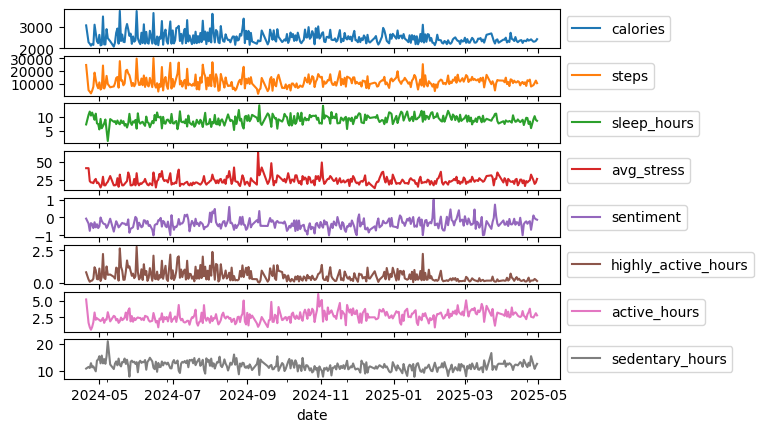

In [455]:
axes = df.plot(x='date', y=['calories', 'steps', 'sleep_hours', 'avg_stress', 'sentiment', 'highly_active_hours', 'active_hours', 'sedentary_hours'], subplots=True)
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Plot artists & health metrics

/var/folders/ms/px9tz7h12yz1zq93xb0hzk8h0000gn/T/ipykernel_50633/4110699171.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['main_artist'] = df_top.apply(pick_first_top_artist, axis=1)


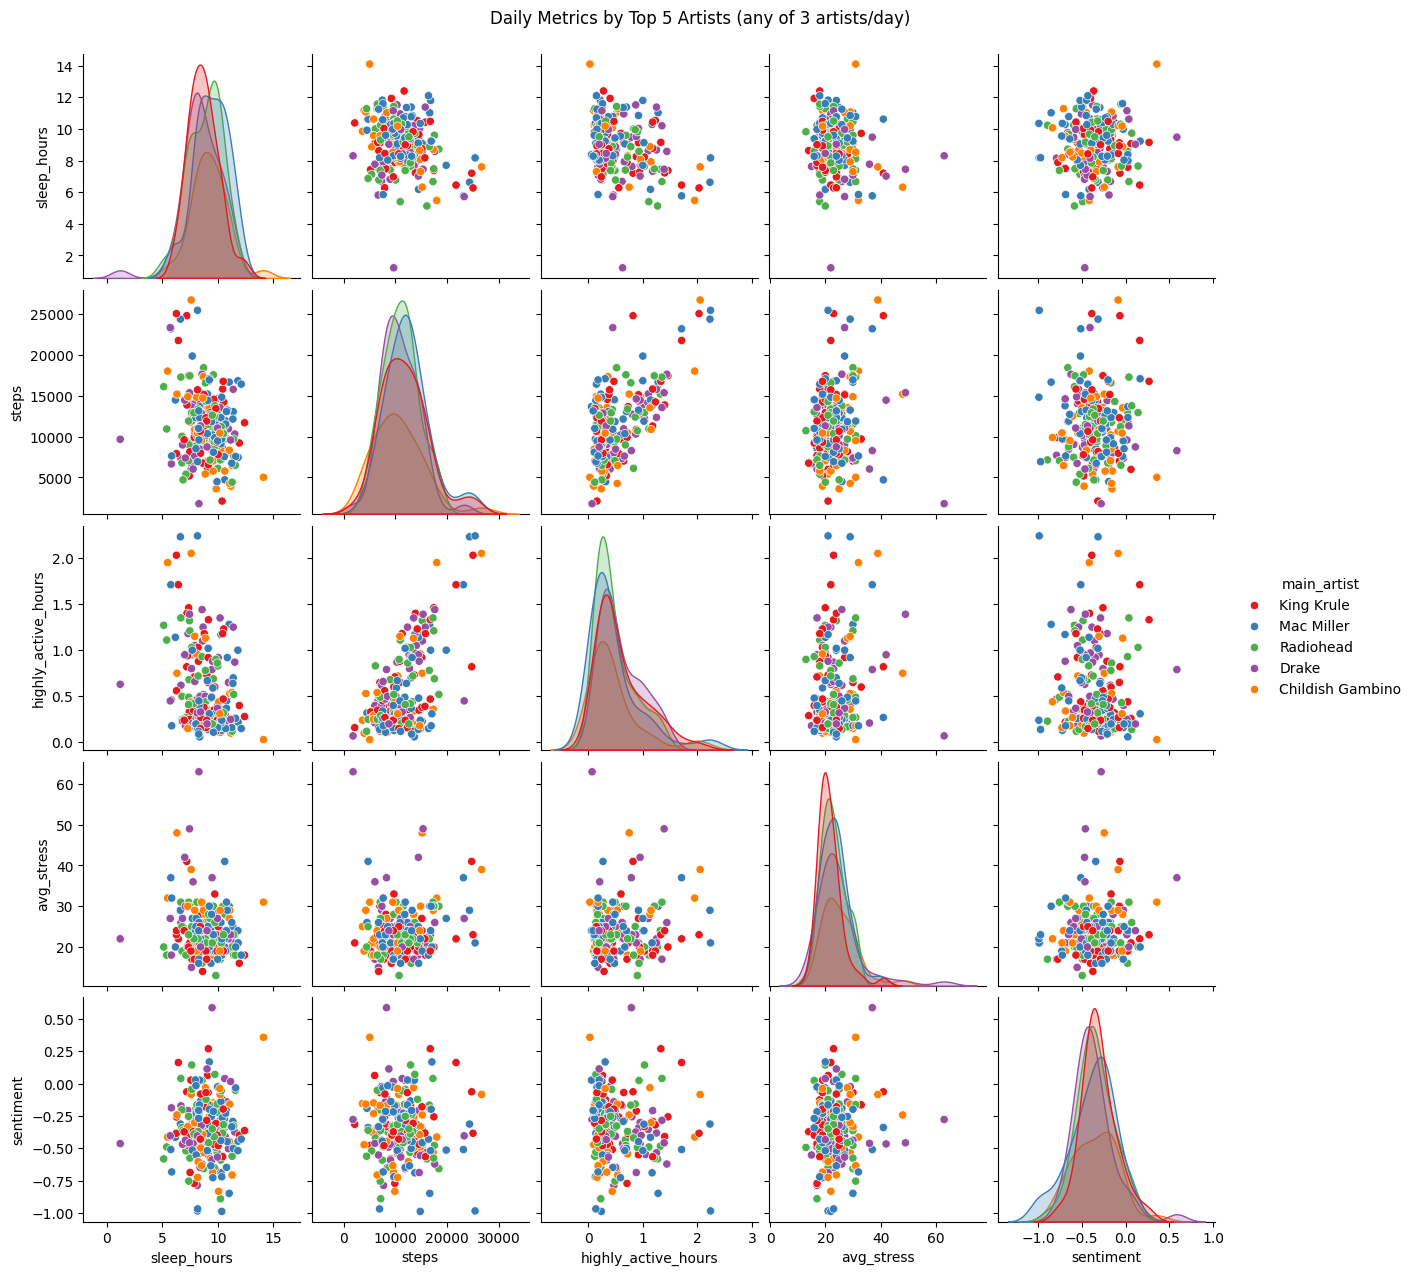

In [ ]:
# Top five artists
top_artists = pd.concat([df['artist1'], df['artist2'], df['artist3']]).value_counts().head(5).index

# Convert to df
df_top = df[
    df[['artist1', 'artist2', 'artist3']].apply(
        lambda row: any(artist in top_artists for artist in row), axis=1
    )
]

def pick_first_top_artist(row):
    """
    Returns first artist in row.
    """
    for artist in row[['artist1', 'artist2', 'artist3']]:
        if artist in top_artists:
            return artist
    return None

df_top['main_artist'] = df_top.apply(pick_first_top_artist, axis=1)
features = ['sleep_hours', 'steps', 'highly_active_hours', 'avg_stress', 'sentiment']

sns.pairplot(df_top[features + ['main_artist']], hue='main_artist', palette='Set1')
plt.suptitle("Daily Metrics by Top 5 Artists (any of 3 artists/day)", y=1.02)
plt.show()

# Kmeans Clustering

## Find silhouette score to determine ideal number of clusters

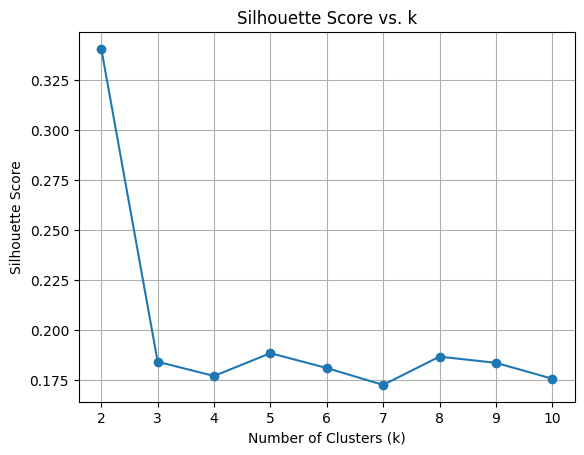

In [526]:
kmeans_df = df[['calories', 'steps', 'sleep_hours', 'highly_active_hours', 'active_hours', 'sedentary_hours', 'avg_stress', 'sentiment']]

# Standardize data
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(kmeans_df)

# Test different k values
scores = []
for k in range(2, 11): 
    kmeans = KMeans(n_clusters=k, init='random')
    labels = kmeans.fit_predict(kmeans_scaled)
    score = silhouette_score(kmeans_scaled, labels)
    scores.append(score)

plt.plot(range(2,11), scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')
plt.grid(True)
plt.show()


## Perform clustering

In [527]:
kmeans = KMeans(n_clusters=2, init='random')
kmeans.fit(kmeans_scaled)
print(f'Cluster centers: {kmeans.cluster_centers_}')

Cluster centers: [[-0.32936615 -0.28384353  0.21499225 -0.31633678 -0.06587506 -0.08777909
  -0.1427771   0.00698311]
 [ 1.61843709  1.3947484  -1.05642743  1.55441351  0.32369642  0.4313283
   0.70157713 -0.03431354]]


## Cluster mean values

/var/folders/ms/px9tz7h12yz1zq93xb0hzk8h0000gn/T/ipykernel_50633/2828513849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_df['cluster'] = kmeans.labels_


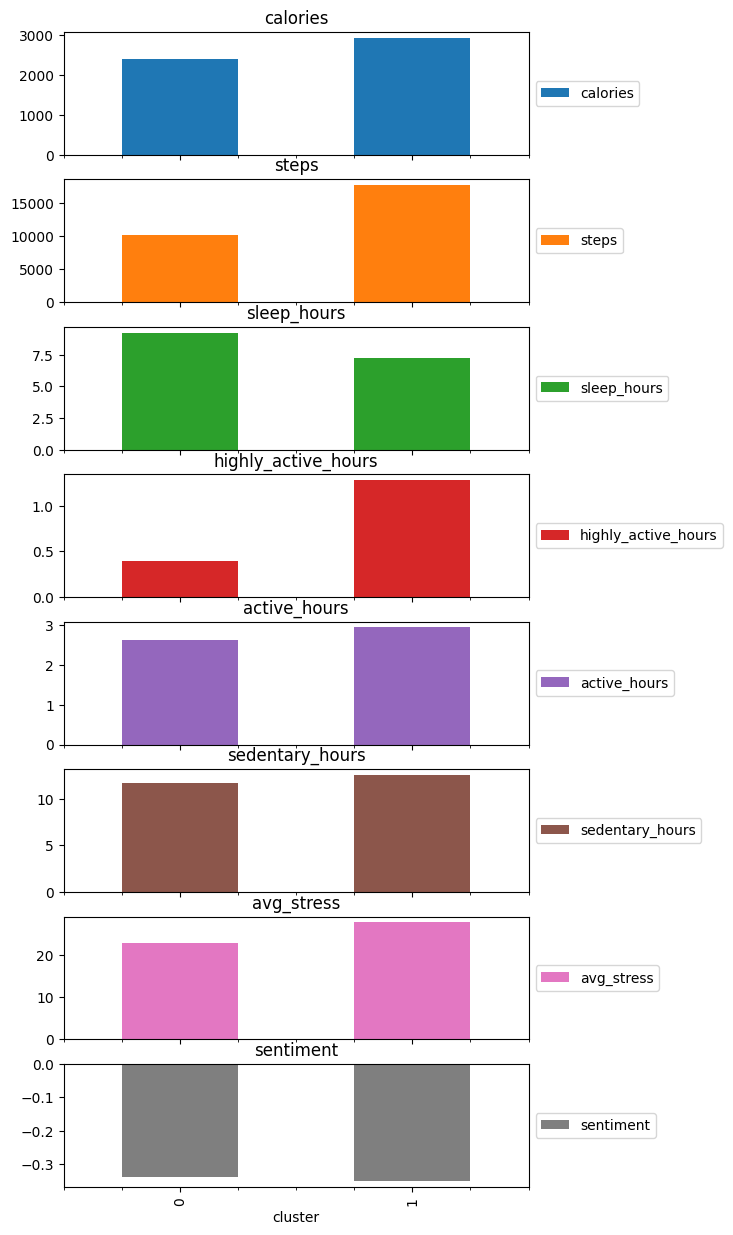

In [546]:
kmeans_df['cluster'] = kmeans.labels_
cluster_data = kmeans_df.groupby('cluster').mean()
axes = cluster_data.plot(kind='bar', subplots=True, figsize=(6, 15))
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()